## 1. Setup and Installation

In [1]:
# Install required packages
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install opencv-python-headless matplotlib pillow pyyaml numpy scikit-learn albumentations
!pip install tensorboard

Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models.segmentation import deeplabv3_resnet101

import numpy as np
import cv2
import yaml
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA L4
Memory Available: 23.80 GB


## 2. Dataset Configuration and YOLO to Segmentation Mask Conversion

In [4]:
# Load dataset configuration
dataset_path = "/content/drive/MyDrive/Capstone Project/CapProject/merged_yolo_dataset"
yaml_path = os.path.join(dataset_path, "dataset.yaml")

with open(yaml_path, 'r') as f:
    config = yaml.safe_load(f)

print("Dataset Configuration:")
print(f"Path: {config.get('path', dataset_path)}")

# Count images directly from directories
train_img_dir = os.path.join(dataset_path, 'train', 'images')
val_img_dir = os.path.join(dataset_path, 'val', 'images')

if os.path.exists(train_img_dir):
    train_count = len([f for f in os.listdir(train_img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
    print(f"Train images: {train_count}")
else:
    print("Train images: Directory not found")

if os.path.exists(val_img_dir):
    val_count = len([f for f in os.listdir(val_img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
    print(f"Val images: {val_count}")
else:
    print("Val images: Directory not found")

print(f"Classes: {config.get('names', ['camouflage_soldier', 'civilian'])}")
print(f"\nNote: Class 1 (civilian) will be treated as background (class 0)")
print(f"Class 0 (camouflage_soldier) will be the foreground (class 1)")

Dataset Configuration:
Path: /content/drive/MyDrive/Capstone Project/CapProject/merged_yolo_dataset
Train images: 5508
Val images: 2150
Classes: {0: 'camouflage_soldier', 1: 'civilian'}

Note: Class 1 (civilian) will be treated as background (class 0)
Class 0 (camouflage_soldier) will be the foreground (class 1)


In [5]:
# Function to convert YOLO segmentation format to binary mask
def yolo_to_mask(label_path, img_shape, target_class=0):
    """
    Convert YOLO v8 segmentation format to binary mask.
    Only segments with target_class (camouflage_soldier = 0) will be marked as foreground.
    Civilians (class 1) will be treated as background.

    Args:
        label_path: Path to YOLO label file
        img_shape: (height, width) of the image
        target_class: Class to segment (0 for camouflage_soldier)

    Returns:
        Binary mask where 1 = camouflage_soldier, 0 = background
    """
    height, width = img_shape
    mask = np.zeros((height, width), dtype=np.uint8)

    if not os.path.exists(label_path):
        return mask

    with open(label_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        data = line.strip().split()
        if len(data) < 5:
            continue

        class_id = int(data[0])

        # Only create mask for camouflage soldiers (class 0)
        # Civilians (class 1) are ignored and remain as background
        if class_id == target_class:
            # Parse polygon points
            points = []
            for i in range(1, len(data), 2):
                if i + 1 < len(data):
                    x = float(data[i]) * width
                    y = float(data[i + 1]) * height
                    points.append([x, y])

            if len(points) >= 3:
                points = np.array(points, dtype=np.int32)
                cv2.fillPoly(mask, [points], 1)

    return mask

## 3. Custom Dataset Class with Advanced Augmentation

In [6]:
class CamouflageSegmentationDataset(Dataset):
    """
    Custom Dataset for Camouflage Soldier Segmentation
    Converts YOLO format to semantic segmentation masks
    """
    def __init__(self, root_dir, split='train', img_size=512, augment=True):
        self.root_dir = root_dir
        self.split = split
        self.img_size = img_size
        self.augment = augment and (split == 'train')

        # Paths
        self.img_dir = os.path.join(root_dir, split, 'images')
        self.label_dir = os.path.join(root_dir, split, 'labels')

        # Get all image files
        self.images = sorted([f for f in os.listdir(self.img_dir)
                             if f.endswith(('.jpg', '.jpeg', '.png'))])

        print(f"{split.upper()} Dataset: {len(self.images)} images found")

        # Define augmentation pipeline for training
        if self.augment:
            self.transform = A.Compose([
                A.RandomResizedCrop(size=(img_size, img_size), scale=(0.7, 1.0)),
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.5),
                A.OneOf([
                    A.GaussNoise(var_limit=(10.0, 50.0)),
                    A.GaussianBlur(blur_limit=(3, 7)),
                    A.MotionBlur(blur_limit=7),
                ], p=0.3),
                A.OneOf([
                    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
                    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20),
                ], p=0.5),
                A.RandomShadow(p=0.3),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2(),
            ])
        else:
            # Validation/Test augmentation
            self.transform = A.Compose([
                A.Resize(height=img_size, width=img_size),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2(),
            ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load label and create mask
        label_name = os.path.splitext(img_name)[0] + '.txt'
        label_path = os.path.join(self.label_dir, label_name)

        # Create binary mask (1 for camouflage_soldier, 0 for background)
        mask = yolo_to_mask(label_path, image.shape[:2], target_class=0)

        # Apply transformations
        transformed = self.transform(image=image, mask=mask)
        image = transformed['image']
        mask = transformed['mask'].long()

        return image, mask

In [7]:
# Create datasets and dataloaders with OPTIMIZED settings for speed
IMG_SIZE = 512
BATCH_SIZE = 16  # ⚡ Increased from 8 to 16 for better GPU utilization
NUM_WORKERS = 4  # ⚡ Increased from 2 to 4 for faster data loading

# If you get OOM (Out of Memory) errors, reduce BATCH_SIZE to 12 or 8
# and increase GRADIENT_ACCUMULATION_STEPS accordingly

train_dataset = CamouflageSegmentationDataset(
    root_dir=dataset_path,
    split='train',
    img_size=IMG_SIZE,
    augment=True
)

val_dataset = CamouflageSegmentationDataset(
    root_dir=dataset_path,
    split='val',
    img_size=IMG_SIZE,
    augment=False
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True,  # ⚡ Reuse worker processes
    prefetch_factor=2  # ⚡ Load 2 batches ahead per worker
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

print(f"\n⚡ OPTIMIZED DataLoader Configuration:")
print(f"Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE} (increased for speed)")
print(f"Num Workers: {NUM_WORKERS} (parallel data loading)")
print(f"Train Batches: {len(train_loader)}")
print(f"Val Batches: {len(val_loader)}")
print(f"\nSpeed optimizations enabled:")
print(f"  ✓ Persistent workers (faster epoch transitions)")
print(f"  ✓ Prefetch factor = 2 (reduced waiting time)")
print(f"  ✓ Pin memory (faster GPU transfer)")

TRAIN Dataset: 5508 images found
VAL Dataset: 2150 images found

⚡ OPTIMIZED DataLoader Configuration:
Image Size: 512x512
Batch Size: 16 (increased for speed)
Num Workers: 4 (parallel data loading)
Train Batches: 345
Val Batches: 135

Speed optimizations enabled:
  ✓ Persistent workers (faster epoch transitions)
  ✓ Prefetch factor = 2 (reduced waiting time)
  ✓ Pin memory (faster GPU transfer)


Training Data Samples:


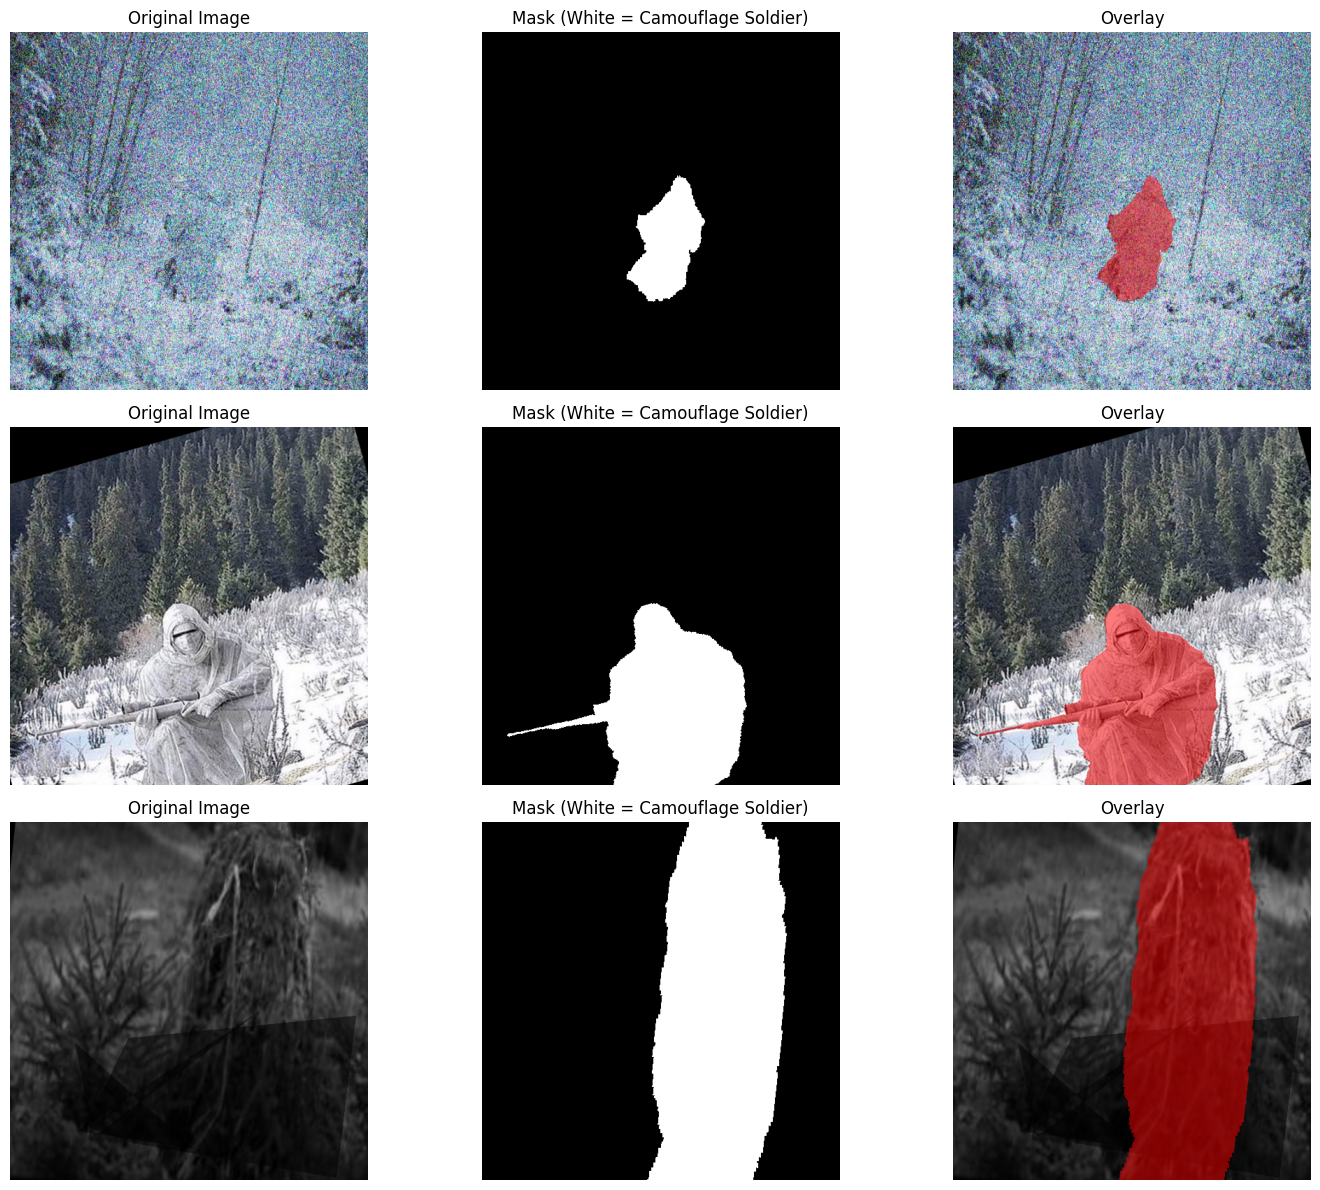

In [8]:
# Visualize sample data
def visualize_samples(dataset, num_samples=4):
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 4))

    for i in range(num_samples):
        idx = np.random.randint(0, len(dataset))
        image, mask = dataset[idx]

        # Denormalize image for visualization
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img_denorm = image * std + mean
        img_denorm = torch.clamp(img_denorm, 0, 1)
        img_np = img_denorm.permute(1, 2, 0).numpy()

        # Mask
        mask_np = mask.numpy()

        # Overlay
        overlay = img_np.copy()
        overlay[mask_np == 1] = overlay[mask_np == 1] * 0.5 + np.array([1, 0, 0]) * 0.5

        if num_samples == 1:
            axes[0].imshow(img_np)
            axes[0].set_title('Original Image')
            axes[0].axis('off')

            axes[1].imshow(mask_np, cmap='gray')
            axes[1].set_title('Mask (White = Camouflage Soldier)')
            axes[1].axis('off')

            axes[2].imshow(overlay)
            axes[2].set_title('Overlay')
            axes[2].axis('off')
        else:
            axes[i, 0].imshow(img_np)
            axes[i, 0].set_title('Original Image')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(mask_np, cmap='gray')
            axes[i, 1].set_title('Mask (White = Camouflage Soldier)')
            axes[i, 1].axis('off')

            axes[i, 2].imshow(overlay)
            axes[i, 2].set_title('Overlay')
            axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

print("Training Data Samples:")
visualize_samples(train_dataset, num_samples=3)

## 4. Build DeepLabV3 Model with Custom Loss Functions

In [9]:
# Custom Combined Loss: Focal Loss + Dice Loss
class FocalLoss(nn.Module):
    """
    Focal Loss for addressing class imbalance
    Focuses training on hard examples
    """
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()


class DiceLoss(nn.Module):
    """
    Dice Loss for better boundary detection
    Particularly good for segmentation tasks
    """
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.softmax(inputs, dim=1)

        # Convert targets to one-hot
        targets_one_hot = torch.zeros_like(inputs)
        targets_one_hot.scatter_(1, targets.unsqueeze(1), 1)

        # Calculate Dice coefficient
        intersection = (inputs * targets_one_hot).sum(dim=(2, 3))
        union = inputs.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))

        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()


class CombinedLoss(nn.Module):
    """
    Combination of Focal Loss and Dice Loss
    Provides both pixel-level accuracy and good boundary detection
    """
    def __init__(self, focal_weight=0.5, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.focal_loss = FocalLoss(alpha=0.75, gamma=2.0)  # Higher alpha for foreground
        self.dice_loss = DiceLoss()
        self.focal_weight = focal_weight
        self.dice_weight = dice_weight

    def forward(self, inputs, targets):
        focal = self.focal_loss(inputs, targets)
        dice = self.dice_loss(inputs, targets)
        return self.focal_weight * focal + self.dice_weight * dice

In [10]:
# Build DeepLabV3 model
def build_deeplabv3(num_classes=2, pretrained=True):
    """
    Build DeepLabV3 model with ResNet-101 backbone

    Args:
        num_classes: Number of output classes (2: background, camouflage_soldier)
        pretrained: Use ImageNet pretrained weights

    Returns:
        DeepLabV3 model
    """
    model = deeplabv3_resnet101(pretrained=pretrained)

    # Modify the classifier for binary segmentation
    model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
    model.aux_classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

    return model

# Initialize model
model = build_deeplabv3(num_classes=2, pretrained=True)
model = model.to(device)

print("DeepLabV3 Model Architecture:")
print(f"Backbone: ResNet-101")
print(f"Output Classes: 2 (Background, Camouflage Soldier)")
print(f"Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


100%|██████████| 233M/233M [00:01<00:00, 239MB/s]


DeepLabV3 Model Architecture:
Backbone: ResNet-101
Output Classes: 2 (Background, Camouflage Soldier)
Total Parameters: 60,986,436
Trainable Parameters: 60,986,436


## 5. Training Configuration and Metrics

In [11]:
# Evaluation metrics
def calculate_iou(pred, target, num_classes=2):
    """Calculate Intersection over Union (IoU) for each class"""
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)

    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()

        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append((intersection / union).item())

    return ious


def calculate_pixel_accuracy(pred, target):
    """Calculate pixel-wise accuracy"""
    correct = (pred == target).sum().item()
    total = target.numel()
    return correct / total


def calculate_dice_coefficient(pred, target, num_classes=2):
    """Calculate Dice Coefficient for each class"""
    dice_scores = []
    pred = pred.view(-1)
    target = target.view(-1)

    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().float()

        pred_sum = pred_inds.sum().float()
        target_sum = target_inds.sum().float()

        if pred_sum + target_sum == 0:
            dice_scores.append(float('nan'))
        else:
            dice = (2. * intersection) / (pred_sum + target_sum)
            dice_scores.append(dice.item())

    return dice_scores

In [12]:
# Training configuration with ANTI-OVERFITTING improvements
EPOCHS = 50
LEARNING_RATE = 5e-5  # 🔧 REDUCED from 1e-4 (more stable, less overfitting)
WEIGHT_DECAY = 5e-4   # 🔧 INCREASED from 1e-5 (stronger L2 regularization)

# ⚡ GRADIENT ACCUMULATION - Simulate larger batches if needed
GRADIENT_ACCUMULATION_STEPS = 1  # Set to 2 or 4 if you reduce BATCH_SIZE

# ⚡ MIXED PRECISION TRAINING - 2-3x faster training!
USE_AMP = True  # Automatic Mixed Precision (FP16)
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)

# 🔧 Add Dropout to model for regularization
class DeepLabV3WithDropout(nn.Module):
    """DeepLabV3 with added dropout layers to prevent overfitting"""
    def __init__(self, base_model, dropout_rate=0.3):
        super().__init__()
        self.base_model = base_model
        self.dropout = nn.Dropout2d(p=dropout_rate)

    def forward(self, x):
        result = self.base_model(x)
        # Apply dropout before final output
        result['out'] = self.dropout(result['out'])
        return result

# Wrap model with dropout
model = DeepLabV3WithDropout(model, dropout_rate=0.3)
model = model.to(device)

# Loss function with stronger class weighting
criterion = CombinedLoss(focal_weight=0.6, dice_weight=0.4)

# Optimizer with STRONGER weight decay and LOWER learning rate
optimizer = optim.AdamW([
    {'params': model.base_model.backbone.parameters(), 'lr': LEARNING_RATE * 0.1, 'weight_decay': WEIGHT_DECAY},
    {'params': model.base_model.classifier.parameters(), 'lr': LEARNING_RATE, 'weight_decay': WEIGHT_DECAY},
    {'params': model.base_model.aux_classifier.parameters(), 'lr': LEARNING_RATE, 'weight_decay': WEIGHT_DECAY}
])

# Learning rate scheduler - more aggressive reduction
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,      # Reduce LR by 50% when plateau
    patience=3,      # 🔧 REDUCED from 5 (faster LR reduction)
    min_lr=1e-7
)

# Early stopping - more aggressive
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=8)  # 🔧 REDUCED from 15 (stop earlier)

print(f"🔧 ANTI-OVERFITTING Training Configuration:")
print(f"Epochs: {EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE} (REDUCED for stability)")
print(f"Weight Decay: {WEIGHT_DECAY} (INCREASED for regularization)")
print(f"Dropout Rate: 0.3 (NEW - prevents memorization)")
print(f"Optimizer: AdamW with differential learning rates")
print(f"Loss Function: Combined (Focal + Dice)")
print(f"Scheduler: ReduceLROnPlateau (patience=3, more aggressive)")
print(f"Early Stopping: Patience = 8 (REDUCED to stop before overfitting)")
print(f"\n🚀 Speed Optimizations:")
print(f"  ✓ Mixed Precision (FP16): {'ENABLED' if USE_AMP else 'DISABLED'} - 2-3x faster!")
print(f"  ✓ Gradient Accumulation Steps: {GRADIENT_ACCUMULATION_STEPS}")
print(f"  ✓ Effective Batch Size: {BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS}")
print(f"\n💡 Expected Improvements:")
print(f"  • Smaller train/val loss gap")
print(f"  • Better validation IoU (target: 0.75+)")
print(f"  • More generalizable model")

🔧 ANTI-OVERFITTING Training Configuration:
Epochs: 50
Learning Rate: 5e-05 (REDUCED for stability)
Weight Decay: 0.0005 (INCREASED for regularization)
Dropout Rate: 0.3 (NEW - prevents memorization)
Optimizer: AdamW with differential learning rates
Loss Function: Combined (Focal + Dice)
Scheduler: ReduceLROnPlateau (patience=3, more aggressive)
Early Stopping: Patience = 8 (REDUCED to stop before overfitting)

🚀 Speed Optimizations:
  ✓ Mixed Precision (FP16): ENABLED - 2-3x faster!
  ✓ Gradient Accumulation Steps: 1
  ✓ Effective Batch Size: 16

💡 Expected Improvements:
  • Smaller train/val loss gap
  • Better validation IoU (target: 0.75+)
  • More generalizable model


## 6. Training Loop with Comprehensive Logging

In [13]:
# ⚡ Enable cuDNN auto-tuner for additional speed boost
torch.backends.cudnn.benchmark = True

# Clear GPU cache before training
torch.cuda.empty_cache()

print("🚀 Additional optimizations applied:")
print("  ✓ cuDNN auto-tuner enabled (finds fastest algorithms)")
print("  ✓ GPU cache cleared")
print("\nReady to train at maximum speed!")

🚀 Additional optimizations applied:
  ✓ cuDNN auto-tuner enabled (finds fastest algorithms)
  ✓ GPU cache cleared

Ready to train at maximum speed!


In [14]:
# ⚡ OPTIMIZED Training and validation functions with Mixed Precision
def train_one_epoch(model, dataloader, criterion, optimizer, device, scaler, accumulation_steps=1):
    model.train()
    running_loss = 0.0
    running_iou = []
    running_accuracy = []

    optimizer.zero_grad()  # Zero gradients at start

    pbar = tqdm(dataloader, desc='Training')
    for batch_idx, (images, masks) in enumerate(pbar):
        images = images.to(device, non_blocking=True)  # ⚡ Non-blocking transfer
        masks = masks.to(device, non_blocking=True)

        # ⚡ Mixed Precision forward pass
        with torch.cuda.amp.autocast(enabled=USE_AMP):
            outputs = model(images)['out']
            loss = criterion(outputs, masks) / accumulation_steps  # Scale loss

        # ⚡ Mixed Precision backward pass
        scaler.scale(loss).backward()

        # Update weights every accumulation_steps
        if (batch_idx + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        # Calculate metrics (without autocast for accuracy)
        with torch.no_grad():
            preds = torch.argmax(outputs, dim=1)
            iou = calculate_iou(preds, masks)
            accuracy = calculate_pixel_accuracy(preds, masks)

        running_loss += loss.item() * accumulation_steps  # Unscale for logging
        running_iou.append(iou[1])  # IoU for camouflage soldier class
        running_accuracy.append(accuracy)

        pbar.set_postfix({
            'loss': f'{loss.item() * accumulation_steps:.4f}',
            'IoU': f'{iou[1]:.4f}' if not np.isnan(iou[1]) else 'N/A',
            'acc': f'{accuracy:.4f}'
        })

    avg_loss = running_loss / len(dataloader)
    avg_iou = np.nanmean(running_iou)
    avg_accuracy = np.mean(running_accuracy)

    return avg_loss, avg_iou, avg_accuracy


def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_iou = []
    running_dice = []
    running_accuracy = []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for images, masks in pbar:
            images = images.to(device, non_blocking=True)  # ⚡ Non-blocking transfer
            masks = masks.to(device, non_blocking=True)

            # ⚡ Mixed Precision forward pass (saves memory during validation)
            with torch.cuda.amp.autocast(enabled=USE_AMP):
                outputs = model(images)['out']
                loss = criterion(outputs, masks)

            # Calculate metrics
            preds = torch.argmax(outputs, dim=1)
            iou = calculate_iou(preds, masks)
            dice = calculate_dice_coefficient(preds, masks)
            accuracy = calculate_pixel_accuracy(preds, masks)

            running_loss += loss.item()
            running_iou.append(iou[1])  # IoU for camouflage soldier
            running_dice.append(dice[1])  # Dice for camouflage soldier
            running_accuracy.append(accuracy)

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'IoU': f'{iou[1]:.4f}' if not np.isnan(iou[1]) else 'N/A',
                'acc': f'{accuracy:.4f}'
            })

    avg_loss = running_loss / len(dataloader)
    avg_iou = np.nanmean(running_iou)
    avg_dice = np.nanmean(running_dice)
    avg_accuracy = np.mean(running_accuracy)

    return avg_loss, avg_iou, avg_dice, avg_accuracy

In [15]:
# Main training loop with OVERFITTING MONITORING
history = {
    'train_loss': [],
    'train_iou': [],
    'train_accuracy': [],
    'val_loss': [],
    'val_iou': [],
    'val_dice': [],
    'val_accuracy':  [],
    'overfitting_gap': []  # Track train/val loss gap
}

best_val_iou = 0.0
best_model_path = '/content/drive/MyDrive/Capstone Project/CapProject/best_deeplabv3_camouflage.pth'

print("=" * 80)
print("Starting Training with Anti-Overfitting Measures...")
print("=" * 80)

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    print("-" * 80)

    # Train with optimized settings
    train_loss, train_iou, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, device, scaler, GRADIENT_ACCUMULATION_STEPS
    )

    # Validate
    val_loss, val_iou, val_dice, val_acc = validate(
        model, val_loader, criterion, device
    )

    # Update learning rate
    scheduler.step(val_loss)

    # Calculate overfitting gap
    overfitting_gap = val_loss - train_loss

    # Save history
    history['train_loss'].append(train_loss)
    history['train_iou'].append(train_iou)
    history['train_accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_iou'].append(val_iou)
    history['val_dice'].append(val_dice)
    history['val_accuracy'].append(val_acc)
    history['overfitting_gap'].append(overfitting_gap)

    # Print epoch summary with overfitting warning
    print(f"\n{'Metric':<20} {'Train':<15} {'Validation':<15}")
    print("-" * 50)
    print(f"{'Loss':<20} {train_loss:<15.4f} {val_loss:<15.4f}")
    print(f"{'IoU (Soldier)':<20} {train_iou:<15.4f} {val_iou:<15.4f}")
    print(f"{'Dice (Soldier)':<20} {'-':<15} {val_dice:<15.4f}")
    print(f"{'Pixel Accuracy':<20} {train_acc:<15.4f} {val_acc:<15.4f}")
    print(f"{'Learning Rate':<20} {optimizer.param_groups[0]['lr']:<15.6f}")

    # Overfitting warning
    if overfitting_gap > 0.05:
        warning_level = "⚠️ MODERATE" if overfitting_gap < 0.1 else "🚨 SEVERE"
        print(f"\n{warning_level} OVERFITTING DETECTED!")
        print(f"Train/Val Loss Gap: {overfitting_gap:.4f}")
        print(f"Regularization is active (Dropout + Weight Decay)")
    else:
        print(f"\n✓ Good generalization (Train/Val gap: {overfitting_gap:.4f})")

    # Save best model
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_iou': val_iou,
            'val_dice': val_dice,
            'val_loss': val_loss,
            'history': history
        }, best_model_path)
        print(f"\n✓ Best model saved! Val IoU: {val_iou:.4f}")

    # Early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("\n" + "=" * 80)
        print(f"Early stopping triggered at epoch {epoch + 1}!")
        print(f"Validation loss hasn't improved for {early_stopping.patience} epochs")
        print("=" * 80)
        break

print("\n" + "=" * 80)
print("Training Complete!")
print(f"Best Validation IoU: {best_val_iou:.4f}")
print(f"Final Overfitting Gap: {history['overfitting_gap'][-1]:.4f}")
print("=" * 80)

Starting Training with Anti-Overfitting Measures...

Epoch 1/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 135/135 [12:38<00:00,  5.62s/it, loss=0.1828, IoU=0.5949, acc=0.9650]



Metric               Train           Validation     
--------------------------------------------------
Loss                 0.2260          0.1818         
IoU (Soldier)        0.4791          0.4807         
Dice (Soldier)       -               0.6037         
Pixel Accuracy       0.8907          0.9233         
Learning Rate        0.000005       

✓ Good generalization (Train/Val gap: -0.0442)

✓ Best model saved! Val IoU: 0.4807

Epoch 2/50
--------------------------------------------------------------------------------


Training:  62%|██████▏   | 213/345 [04:17<02:39,  1.21s/it, loss=0.1565, IoU=0.7186, acc=0.9578]


KeyboardInterrupt: 

## 7. Visualize Training Results

In [ ]:
# Plot training history with OVERFITTING ANALYSIS
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Overfitting Gap (NEW!)
axes[0, 1].plot(history['overfitting_gap'], label='Val Loss - Train Loss',
                marker='o', linewidth=2, color='red')
axes[0, 1].axhline(y=0.05, color='orange', linestyle='--', label='Moderate Overfitting (0.05)')
axes[0, 1].axhline(y=0.1, color='red', linestyle='--', label='Severe Overfitting (0.1)')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Loss Gap', fontsize=12)
axes[0, 1].set_title('Overfitting Gap Analysis', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# IoU
axes[0, 2].plot(history['train_iou'], label='Train IoU', marker='o', linewidth=2)
axes[0, 2].plot(history['val_iou'], label='Val IoU', marker='s', linewidth=2)
axes[0, 2].set_xlabel('Epoch', fontsize=12)
axes[0, 2].set_ylabel('IoU', fontsize=12)
axes[0, 2].set_title('IoU for Camouflage Soldier Class', fontsize=14, fontweight='bold')
axes[0, 2].legend(fontsize=11)
axes[0, 2].grid(True, alpha=0.3)

# Accuracy
axes[1, 0].plot(history['train_accuracy'], label='Train Accuracy', marker='o', linewidth=2)
axes[1, 0].plot(history['val_accuracy'], label='Val Accuracy', marker='s', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Pixel Accuracy', fontsize=12)
axes[1, 0].set_title('Pixel-wise Accuracy', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# Dice Coefficient
axes[1, 1].plot(history['val_dice'], label='Val Dice', marker='s', color='green', linewidth=2)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Dice Coefficient', fontsize=12)
axes[1, 1].set_title('Dice Coefficient for Camouflage Soldier', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

# Learning Rate Schedule
axes[1, 2].plot(range(1, len(history['train_loss']) + 1),
                [optimizer.param_groups[0]['lr']] * len(history['train_loss']),
                marker='o', linewidth=2, color='purple')
axes[1, 2].set_xlabel('Epoch', fontsize=12)
axes[1, 2].set_ylabel('Learning Rate', fontsize=12)
axes[1, 2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 2].set_yscale('log')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Capstone Project/CapProject/training_history_detailed.png',
            dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "=" * 80)
print("TRAINING SUMMARY")
print("=" * 80)
print(f"\nBest Epoch: {np.argmax(history['val_iou']) + 1}")
print(f"Best Val IoU: {max(history['val_iou']):.4f}")
print(f"Best Val Dice: {history['val_dice'][np.argmax(history['val_iou'])]:.4f}")
print(f"\nFinal Metrics:")
print(f"  Train Loss: {history['train_loss'][-1]:.4f}")
print(f"  Val Loss: {history['val_loss'][-1]:.4f}")
print(f"  Overfitting Gap: {history['overfitting_gap'][-1]:.4f}")
print(f"\nOverfitting Assessment:")
final_gap = history['overfitting_gap'][-1]
if final_gap < 0.05:
    print("  ✓ EXCELLENT: Minimal overfitting, good generalization")
elif final_gap < 0.1:
    print("  ⚠️ MODERATE: Some overfitting, acceptable for deployment")
else:
    print("  🚨 SEVERE: Significant overfitting, consider more regularization")
print("=" * 80)

print("\nTraining curves saved!")

## 8. Load Best Model and Evaluate

In [ ]:
# Load best model
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("Best Model Statistics:")
print(f"Epoch: {checkpoint['epoch'] + 1}")
print(f"Validation IoU: {checkpoint['val_iou']:.4f}")
print(f"Validation Dice: {checkpoint['val_dice']:.4f}")
print(f"Validation Loss: {checkpoint['val_loss']:.4f}")

In [ ]:
# Comprehensive evaluation on validation set
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc='Evaluating'):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)['out']
            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu().numpy())
            all_targets.append(masks.cpu().numpy())

    all_preds = np.concatenate([p.flatten() for p in all_preds])
    all_targets = np.concatenate([t.flatten() for t in all_targets])

    return all_preds, all_targets

# Evaluate
preds, targets = evaluate_model(model, val_loader, device)

# Calculate comprehensive metrics
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

print("\n" + "=" * 80)
print("COMPREHENSIVE EVALUATION RESULTS")
print("=" * 80)

# Overall metrics
accuracy = accuracy_score(targets, preds)
print(f"\nOverall Pixel Accuracy: {accuracy:.4f}")

# Per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    targets, preds, average=None, labels=[0, 1]
)

print("\nPer-Class Metrics:")
print("-" * 80)
print(f"{'Class':<25} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<12}")
print("-" * 80)
print(f"{'Background':<25} {precision[0]:<12.4f} {recall[0]:<12.4f} {f1[0]:<12.4f} {support[0]:<12}")
print(f"{'Camouflage Soldier':<25} {precision[1]:<12.4f} {recall[1]:<12.4f} {f1[1]:<12.4f} {support[1]:<12}")
print("-" * 80)

# Calculate IoU for each class
unique_labels = np.unique(targets)
class_iou = []
for label in unique_labels:
    pred_mask = preds == label
    true_mask = targets == label
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()
    iou = intersection / union if union > 0 else 0
    class_iou.append(iou)

print(f"\nIoU Scores:")
print(f"Background IoU: {class_iou[0]:.4f}")
print(f"Camouflage Soldier IoU: {class_iou[1]:.4f}")
print(f"Mean IoU: {np.mean(class_iou):.4f}")

print("\n" + "=" * 80)

## 9. Visualize Predictions

In [ ]:
# Visualize predictions on validation set
def visualize_predictions(model, dataset, device, num_samples=6):
    model.eval()

    fig, axes = plt.subplots(num_samples, 4, figsize=(16, num_samples * 4))

    indices = np.random.choice(len(dataset), num_samples, replace=False)

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, mask = dataset[idx]

            # Predict
            image_input = image.unsqueeze(0).to(device)
            output = model(image_input)['out']
            pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()

            # Denormalize image
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            img_denorm = image * std + mean
            img_denorm = torch.clamp(img_denorm, 0, 1)
            img_np = img_denorm.permute(1, 2, 0).numpy()

            mask_np = mask.numpy()

            # Create overlays
            overlay_true = img_np.copy()
            overlay_true[mask_np == 1] = overlay_true[mask_np == 1] * 0.5 + np.array([0, 1, 0]) * 0.5

            overlay_pred = img_np.copy()
            overlay_pred[pred == 1] = overlay_pred[pred == 1] * 0.5 + np.array([1, 0, 0]) * 0.5

            # Calculate IoU for this sample
            intersection = np.logical_and(pred == 1, mask_np == 1).sum()
            union = np.logical_or(pred == 1, mask_np == 1).sum()
            iou = intersection / union if union > 0 else 0

            # Plot
            axes[i, 0].imshow(img_np)
            axes[i, 0].set_title('Original Image')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(mask_np, cmap='gray')
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')

            axes[i, 2].imshow(pred, cmap='gray')
            axes[i, 2].set_title(f'Prediction (IoU: {iou:.3f})')
            axes[i, 2].axis('off')

            axes[i, 3].imshow(img_np)
            axes[i, 3].imshow(pred, cmap='Reds', alpha=0.5)
            axes[i, 3].set_title('Overlay')
            axes[i, 3].axis('off')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Capstone Project/CapProject/predictions_visualization.png',
                dpi=300, bbox_inches='tight')
    plt.show()

visualize_predictions(model, val_dataset, device, num_samples=6)

## 10. Inference Function for Website Integration

In [ ]:
# Inference function for deployment
class CamouflageSegmentor:
    """
    Wrapper class for easy inference on new images.
    Suitable for web application integration.
    """
    def __init__(self, model_path, device='cuda'):
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')

        # Load model
        self.model = build_deeplabv3(num_classes=2, pretrained=False)
        checkpoint = torch.load(model_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)
        self.model.eval()

        # Define transformation
        self.transform = A.Compose([
            A.Resize(height=512, width=512),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])

        print(f"Model loaded successfully on {self.device}")

    def predict(self, image_path, return_overlay=True, confidence_threshold=0.5):
        """
        Predict camouflage soldier segmentation on an image

        Args:
            image_path: Path to input image
            return_overlay: Whether to return overlay visualization
            confidence_threshold: Confidence threshold for predictions

        Returns:
            Dictionary containing prediction results
        """
        # Load image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_shape = image.shape[:2]

        # Transform
        transformed = self.transform(image=image)
        image_tensor = transformed['image'].unsqueeze(0).to(self.device)

        # Predict
        with torch.no_grad():
            output = self.model(image_tensor)['out']
            probabilities = torch.softmax(output, dim=1)
            pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()
            confidence = probabilities[0, 1].cpu().numpy()  # Confidence for soldier class

        # Resize back to original size
        pred_mask_resized = cv2.resize(
            pred_mask.astype(np.uint8),
            (original_shape[1], original_shape[0]),
            interpolation=cv2.INTER_NEAREST
        )
        confidence_resized = cv2.resize(
            confidence,
            (original_shape[1], original_shape[0]),
            interpolation=cv2.INTER_LINEAR
        )

        # Apply confidence threshold
        pred_mask_filtered = (confidence_resized > confidence_threshold).astype(np.uint8)

        # Calculate statistics
        total_pixels = pred_mask_resized.shape[0] * pred_mask_resized.shape[1]
        soldier_pixels = np.sum(pred_mask_filtered)
        coverage_percentage = (soldier_pixels / total_pixels) * 100

        result = {
            'mask': pred_mask_filtered,
            'confidence_map': confidence_resized,
            'soldier_pixels': int(soldier_pixels),
            'total_pixels': int(total_pixels),
            'coverage_percentage': float(coverage_percentage),
            'has_camouflage_soldier': soldier_pixels > 0
        }

        # Create overlay if requested
        if return_overlay:
            overlay = image.copy()
            overlay[pred_mask_filtered == 1] = overlay[pred_mask_filtered == 1] * 0.6 + np.array([255, 0, 0]) * 0.4
            result['overlay'] = overlay

        return result

    def predict_batch(self, image_paths, confidence_threshold=0.5):
        """
        Predict on multiple images

        Args:
            image_paths: List of image paths
            confidence_threshold: Confidence threshold for predictions

        Returns:
            List of prediction results
        """
        results = []
        for image_path in tqdm(image_paths, desc='Processing images'):
            result = self.predict(image_path, return_overlay=False, confidence_threshold=confidence_threshold)
            results.append({
                'image_path': image_path,
                **result
            })
        return results

# Initialize segmentor
segmentor = CamouflageSegmentor(best_model_path, device=device)
print("\nSegmentor ready for inference!")

In [ ]:
# Test inference on sample images
def test_inference(segmentor, dataset, num_samples=4):
    """Test the segmentor on random samples"""
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 4))

    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for i, idx in enumerate(indices):
        # Get image path
        img_name = dataset.images[idx]
        img_path = os.path.join(dataset.img_dir, img_name)

        # Predict
        result = segmentor.predict(img_path, return_overlay=True, confidence_threshold=0.5)

        # Load original image
        original_image = cv2.imread(img_path)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

        # Plot
        axes[i, 0].imshow(original_image)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(result['mask'], cmap='gray')
        axes[i, 1].set_title(f"Detection: {'Yes' if result['has_camouflage_soldier'] else 'No'}\n" +
                            f"Coverage: {result['coverage_percentage']:.2f}%")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(result['overlay'])
        axes[i, 2].set_title('Segmentation Overlay')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Capstone Project/CapProject/inference_test.png',
                dpi=300, bbox_inches='tight')
    plt.show()

test_inference(segmentor, val_dataset, num_samples=4)

## 11. Export Model for Production

In [ ]:
# Export model for production use
export_dir = '/content/drive/MyDrive/Capstone Project/CapProject/models'
os.makedirs(export_dir, exist_ok=True)

# 1. Export as TorchScript for faster inference
model.eval()
example_input = torch.randn(1, 3, 512, 512).to(device)

try:
    traced_model = torch.jit.trace(model, example_input)
    torchscript_path = os.path.join(export_dir, 'deeplabv3_camouflage_torchscript.pt')
    traced_model.save(torchscript_path)
    print(f"✓ TorchScript model saved to: {torchscript_path}")
except Exception as e:
    print(f"✗ TorchScript export failed: {e}")

# 2. Export ONNX for web deployment
try:
    onnx_path = os.path.join(export_dir, 'deeplabv3_camouflage.onnx')
    torch.onnx.export(
        model,
        example_input,
        onnx_path,
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )
    print(f"✓ ONNX model saved to: {onnx_path}")
except Exception as e:
    print(f"✗ ONNX export failed: {e}")

# 3. Save model state dict (most compatible)
state_dict_path = os.path.join(export_dir, 'deeplabv3_camouflage_state_dict.pth')
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': {
        'num_classes': 2,
        'architecture': 'deeplabv3_resnet101',
        'input_size': 512
    },
    'training_info': {
        'best_val_iou': checkpoint['val_iou'],
        'best_val_dice': checkpoint['val_dice'],
        'epoch': checkpoint['epoch']
    },
    'class_names': {
        0: 'background',
        1: 'camouflage_soldier'
    }
}, state_dict_path)
print(f"✓ State dict saved to: {state_dict_path}")

print("\n" + "=" * 80)
print("MODEL EXPORT COMPLETE")
print("=" * 80)
print(f"Export directory: {export_dir}")
print("\nFiles created:")
print("  1. TorchScript (.pt) - For PyTorch deployment")
print("  2. ONNX (.onnx) - For web/cross-platform deployment")
print("  3. State Dict (.pth) - For Python applications")
print("\nThese models can be integrated into your website!")